# Histogram Plots

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from itertools import combinations
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pkg.plot import Figure, Panel, SmartSVG, Text, stripplot, stripplot_cov
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_csv(
    "../../twins/data/subject_metadata/truncated_restricted_processed_valid_subjects.csv"
)

df = df.sort_values("Subject")
df.head()

# remove singletons
uniques, counts = np.unique(df.Family_ID, return_counts=True)

singletons = []

for unique, count in zip(uniques, counts):
    if count == 1:
        sub = df[df.Family_ID == unique].Subject.iloc[0]

        singletons.append(sub)

singleton_idx = df.Subject.isin(singletons).values

df = df[~singleton_idx]

male_idx = df.Gender == "M"
female_idx = df.Gender == "F"

In [3]:
scales = ["exact", "global", "vertex"]
rel_names = ["mz", "dz", "sib", "step", "unrel"]

# rel_names = ["mz", "dz", "sib", "unrel"]

genders = ["all", "male", "female"]

## Plot for each parcellation

In [206]:
p = Path("../../twins/notebooks/outs/1-connectome-distances/arrs/")

relationships = np.load(
    "../../twins/notebooks/outs/1-connectome-distances/arrs/relationship_distances.npy"
)
relationships = relationships[~singleton_idx, :][:, ~singleton_idx]


parc_full = "Schaefer1000_space-MNI152NLin6_res-1x1x1"
parc = "Schaefer1000"
distances = []

for scale in ["exact", "global", "vertex"]:
    file = list(p.glob(f"{scale}*{parc}.npy"))[0]
    dist = np.load(file)

    dist_mat = squareform(np.linalg.norm(dist, axis=(1, 2)))
    dist_mat = dist_mat[~singleton_idx, :][:, ~singleton_idx]

    cov = np.load(
        f"../../twins/notebooks/outs/5-covariate-distances/arrs/covariate_distances_{parc_full}.npy"
    )
    cov = squareform(np.linalg.norm(cov, axis=(1, 2)))
    cov = cov[~singleton_idx, :][:, ~singleton_idx]

    for gender in genders:
        if gender == "male":
            X = squareform(dist_mat[male_idx, :][:, male_idx])
            Y = squareform(relationships[male_idx, :][:, male_idx])
            Z = squareform(cov[male_idx, :][:, male_idx])
        elif gender == "female":
            X = squareform(dist_mat[female_idx, :][:, female_idx])
            Y = squareform(relationships[female_idx, :][:, female_idx])
            Z = squareform(cov[female_idx, :][:, female_idx])
        else:
            X = squareform(dist_mat)
            Y = squareform(relationships)
            Z = squareform(cov)

        for i in range(5):
            if i == 3:
                continue
            if i == 4:
                idx = np.random.choice(np.where(Y == 4)[0], 500, replace=False)
            else:
                idx = Y == i
            for j, q in zip(X[idx], Z[idx]):
                distances.append([j, q, rel_names[i], scale, gender])

plot_df = pd.DataFrame(
    distances, columns=["distance", "covariate", "relationship", "scale", "gender"]
)

In [6]:
plot_df = pd.read_csv("../data/pvalues.csv")

In [7]:
plot_df

Parcellation Gender test      model    pvalue
0       Glasser      M    a      Exact  0.081550
1       Glasser      F    a      Exact  0.031428
2       Glasser    All    a      Exact  0.005481
3       Glasser      M    a     Global  0.101967
4       Glasser      F    a     Global  0.013838
5       Glasser    All    a     Global  0.004286
6       Glasser      M    a     Vertex  0.323899
7       Glasser      F    a     Vertex  0.023016
8       Glasser    All    a     Vertex  0.006115
9       Glasser    All    b      Exact  0.001195
10      Glasser      F    b      Exact  0.000947
11      Glasser      M    b      Exact  0.002723
12      Glasser    All    b     Global  0.001117
13      Glasser      F    b     Global  0.000917
14      Glasser      M    b     Global  0.002588
15      Glasser    All    b     Vertex  0.008350
16      Glasser      F    b     Vertex  0.004841
17      Glasser      M    b     Vertex  0.007018
18      Glasser      M    c  Covariate  0.009771
19      Glasser      F    c  Covariate  0.020404
20      Glasser    All    c  Covariate  0.000158
21      Glasser    All    d      Exact  0.000500
22      Glasser      M    d      Exact  0.001000
23      Glasser      F    d      Exact  0.001000
24      Glasser    All    d     Global  0.001000
25      Glasser      M    d     Global  0.001499
26      Glasser      F    d     Global  0.001499
27      Glasser    All    d     Vertex  0.001499
28      Glasser      M    d     Vertex  0.001000
29      Glasser      F    d     Vertex  0.001000
30      Glasser    All    e      Exact  0.001999
31      Glasser      M    e      Exact  0.001999
32      Glasser      F    e      Exact  0.001000
33      Glasser    All    e     Global  0.001499
34      Glasser      M    e     Global  0.001999
35      Glasser      F    e     Global  0.003498
36      Glasser    All    e     Vertex  0.002999
37      Glasser      M    e     Vertex  0.002499
38      Glasser      F    e     Vertex  0.000500

In [213]:
plot_df.gender.replace(to_replace=dict(All="all", F="female", M="male"), inplace=True)

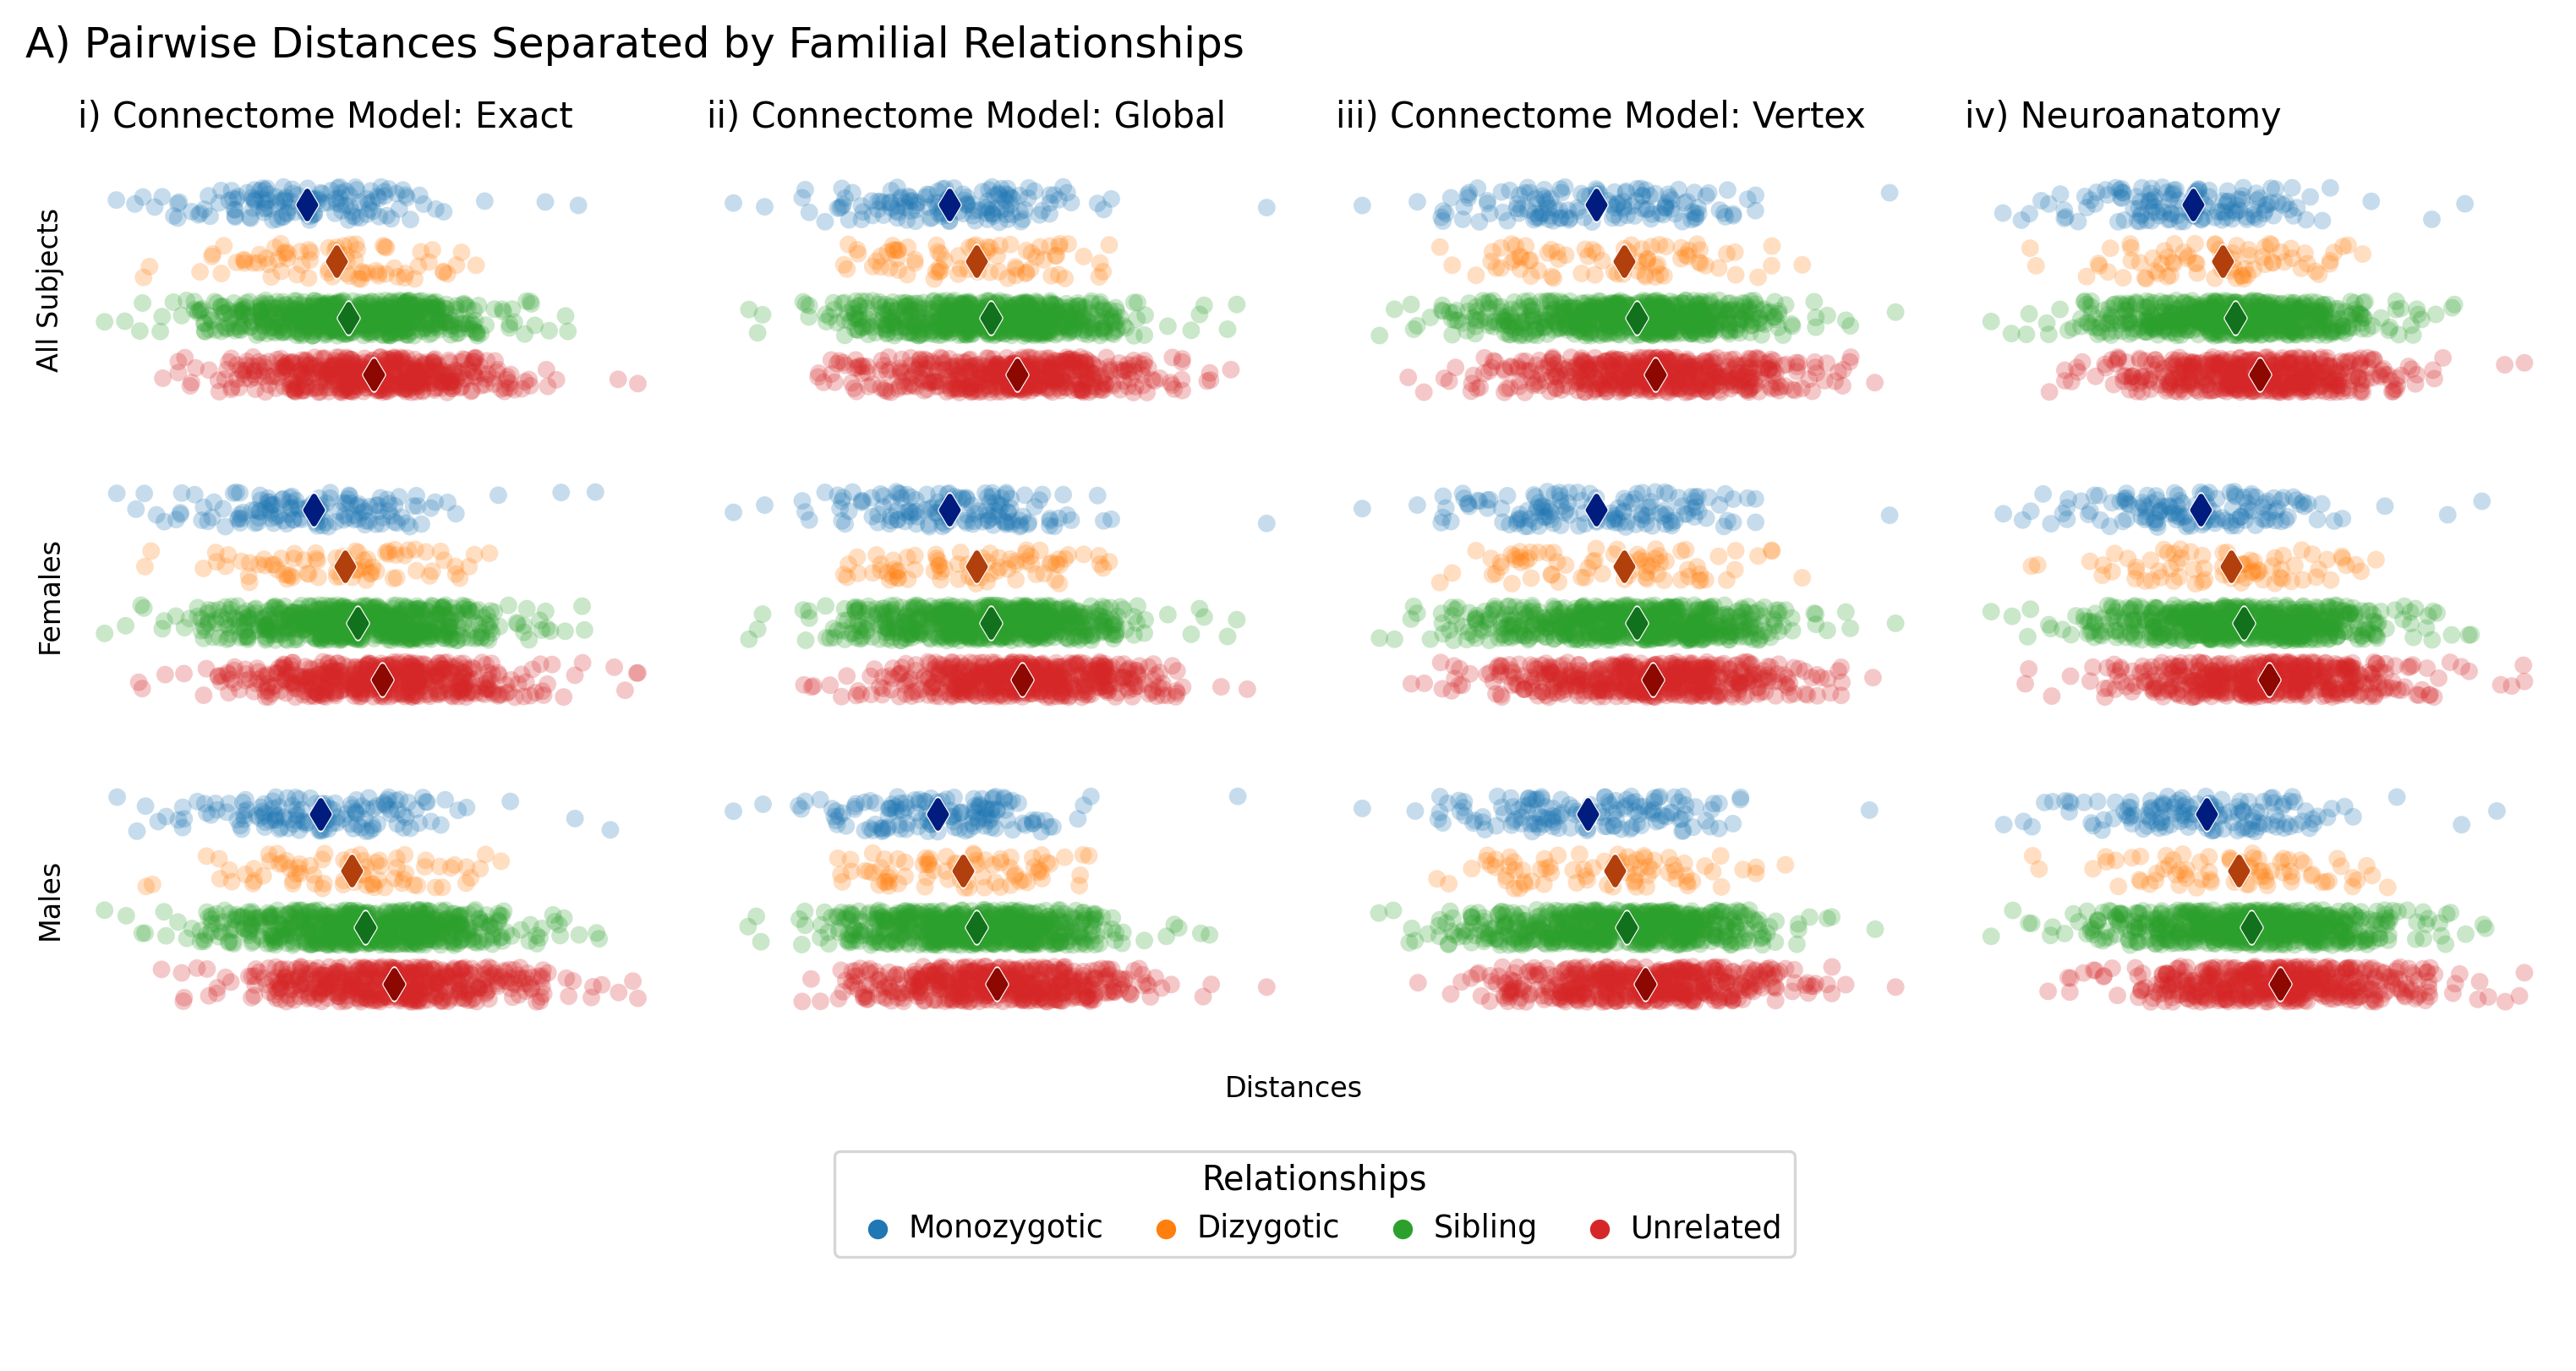

In [218]:
sns.set_context("paper", font_scale=1)

gender = ["all", "female", "male"]
scale = ["exact", "global", "vertex"]
layout = [
    ["exact-all", "global-all", "vertex-all", "covariate-all"],
    ["exact-female", "global-female", "vertex-female", "covariate-female"],
    ["exact-male", "global-male", "vertex-male", "covariate-male"],
    ["legend", "legend", "legend", "legend"],
]

col_names = [
    "i) Connectome Model: Exact",
    "ii) Connectome Model: Global",
    "iii) Connectome Model: Vertex",
]

fig, axes = plt.subplot_mosaic(
    layout,
    figsize=(10, 5),
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1, 1, 1],
    dpi=300,
    constrained_layout=True,
)

ax_arr = np.array([val for key, val in axes.items() if key != "legend"]).reshape(3, -1)


handles, labels = stripplot(plot_df, ax_arr[:3, :3], col_names=col_names)
stripplot_cov(plot_df, ax_arr[:3, -1])

# handle limits
limits = [[a.get_xlim() for a in b] for b in ax_arr]


ax = axes["legend"]
sns.despine(bottom=True, left=True, top=True, right=True, ax=ax)
ax.legend(
    handles[:4],
    ["Monozygotic", "Dizygotic", "Sibling", "Unrelated"],
    loc=10,
    title="Relationships",
    ncol=4,
    handletextpad=0,
    columnspacing=1,
    frameon=True,
)
ax.axis("off")


fig.suptitle(
    "A) Pairwise Distances Separated by Familial Relationships",
    x=0.0,
    y=1.05,
    horizontalalignment="left",
    fontsize=12,
)
fig.supxlabel("Distances", y=0.2, fontsize=8)


fig.savefig("./figures/4a.svg", bbox_inches="tight")

## Part B

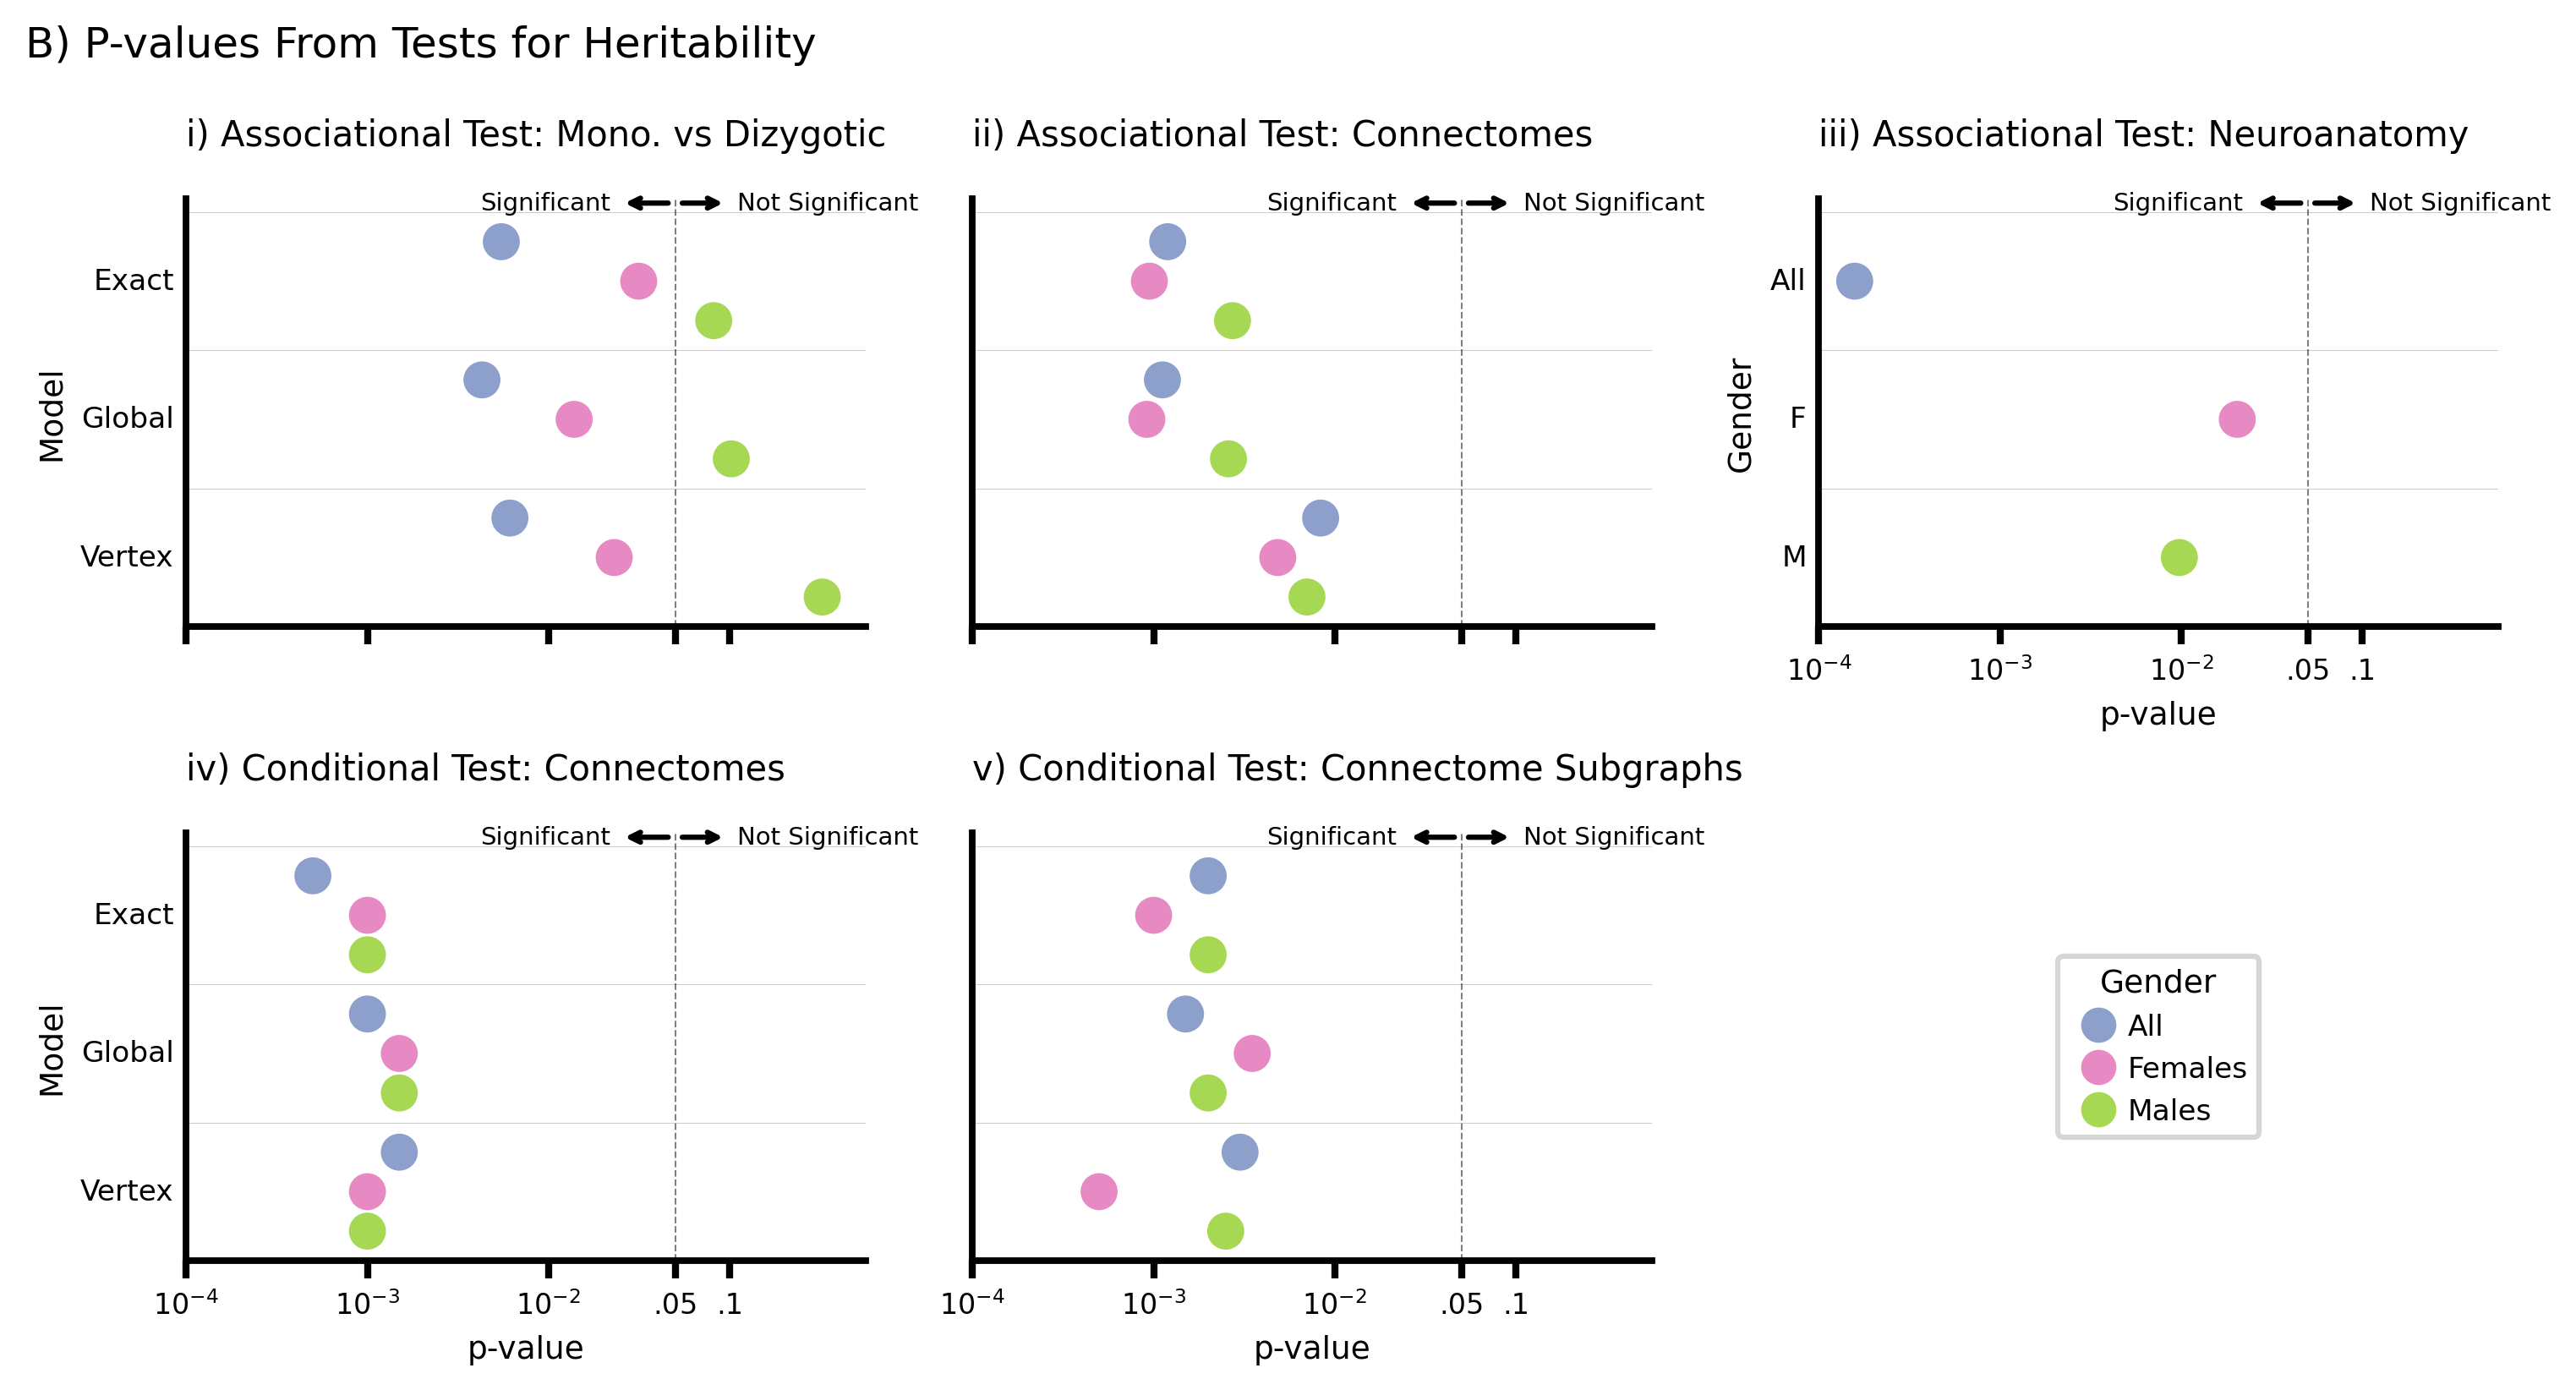

In [113]:
sns.set_context("talk", font_scale=0.5)

# sns.set_context("talk", font_scale=0.65)
data = pd.read_csv("../data/pvalues.csv")

# options for plots
gap = 0.5
fontdict = dict(fontsize=10)

ytickloc = [1, 2, 3]

titles = [
    "i) Associational Test: Mono. vs Dizygotic",
    "ii) Associational Test: Connectomes",
    "iii) Associational Test: Neuroanatomy",
    "iv) Conditional Test: Connectomes",
    "v) Conditional Test: Connectome Subgraphs",
]

# setting variables
models = ["Exact", "Global", "Vertex"]
covariate_model = ["Covariate"]
tests = pd.unique(data.test)
genders = ["All", "F", "M"]

nsubplots = len(tests)  # tests
nmodels = len(models)  # model
ngenders = len(genders)  # gender

# create empty fig
width = nsubplots * 2

fig, all_axes = plt.subplot_mosaic(
    """
    ABC
    DEF
    """,
    figsize=(width, 5),
    dpi=300,
    # sharex=True,
    constrained_layout=True,
)

axes = {key: ax for key, ax in all_axes.items() if key != "F"}

for cdx, ax in enumerate(axes.values()):
    test = tests[cdx]
    test_data = data.loc[data.test == test]
    test_data = test_data.sort_values(["model", "Gender"])

    # xs = np.log10(test_data.pvalue)
    xs = test_data.pvalue
    length = len(xs)
    if length == 9:
        ys = []
        for ytick in ytickloc:
            spacing = 1 / (3 + gap)
            ys.extend([ytick - spacing, ytick, ytick + spacing])
    else:
        ys = ytickloc

    colors = ["#8da0cb", "#e78ac3", "#a6d854"]
    scatter = ax.scatter(
        xs,
        ys,
        c=colors * (length // 3),
    )


for idx, (label, ax) in enumerate(axes.items()):
    sns.despine(ax=ax)

    # xaxis
    ax.set_xscale("log")
    ax.set_xlim(10**-3, 10**-0.25)
    xtick_loc = [0.0001, 0.001, 0.01, 0.05, 0.1]
    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(
        ["$10^{-4}$", "$10^{-3}$", "$10^{-2}$", ".05", ".1"],
        # rotation=90,
        fontdict=dict(fontsize=8),
    )
    ax.tick_params(axis="x", length=5, width=2)
    ax.set_xlabel("p-value")
    ax.minorticks_off()

    if label in ["A", "B"]:
        ax.set_xticklabels([])
        ax.set_xlabel("")

    # yaxis
    ax.set_yticks([])
    ax.tick_params(axis="y", length=0)
    ax.set_ylim(0.4, 3.5)
    ax.invert_yaxis()

    # set title
    ax.set_title(titles[idx], loc="left", fontdict=fontdict, pad=15)

    # lines
    ax.axvline(0.05, ls="--", lw=0.5, c="gray")  # set alpha-0.05 line
    for ytick in ytickloc:
        ax.axhline(ytick - 0.5, ls="-", lw=0.25, alpha=0.2, c="k")

    # significant labeling
    ymin, ymax = ax.get_ylim()
    ymax += 0.035
    ax.annotate(
        "Significant",
        xy=(0.05, ymax),
        xytext=(0.022, ymax),
        size=7,
        arrowprops=dict(
            facecolor="black",
            arrowstyle="<-",
        ),
        horizontalalignment="right",
        verticalalignment="center",
    )
    ax.annotate(
        "Not Significant",
        xy=(0.05, ymax),
        xytext=(0.11, ymax),
        size=7,
        arrowprops=dict(
            facecolor="black",
            arrowstyle="<-",
        ),
        horizontalalignment="left",
        verticalalignment="center",
    )

    if label in ["A", "D"]:
        # yaxis
        ax.set_ylabel("Model")
        ax.set_yticks(
            ticks=ytickloc,
            labels=models,
            # rotation=90,
            va="center",
        )

    #         # Twin ax
    #         twin_ax = ax.twinx()
    #         twin_ax.yaxis.set_ticks_position("left")
    #         twin_ax.tick_params(axis="y", direction="in", pad=-5, length=0)
    #         sns.despine(ax=twin_ax)
    #         twin_ax.set_ylim(ax.get_ylim())

    #         # inner ticks
    #         ys = []
    #         for ytick in ytickloc:
    #             spacing = 1 / (3 + gap)
    #             ys.extend([ytick - spacing, ytick, ytick + spacing])
    #         twin_ax.set_yticks(
    #             ys,
    #             labels=genders * 3,
    #         )

    #         for tick in twin_ax.get_yticklabels():
    #             tick.set_horizontalalignment("left")

    if label == "C":
        ax.set_ylabel("Gender")
        ax.set_yticks(ticks=ytickloc, labels=genders, va="center")

colors = ["#8da0cb", "#e78ac3", "#a6d854"]

handles = [
    mpl.lines.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Circle",
        markerfacecolor=c,
        markersize=10,
        markeredgewidth=0.0,
    )
    for c in colors
]

ax = all_axes["F"]
sns.despine(bottom=True, left=True, top=True, right=True, ax=ax)
ax.legend(
    handles,
    ["All", "Females", "Males"],
    loc=10,
    title="Gender",
    ncol=1,
    handletextpad=0,
    columnspacing=1,
    frameon=True,
)
ax.axis("off")

fig.suptitle(
    "B) P-values From Tests for Heritability",
    x=0.0,
    y=1.065,
    horizontalalignment="left",
    fontsize=12,
)

fig.savefig("./figures/5b.svg", bbox_inches="tight")

## Merge

In [11]:
dist = SmartSVG(f"./figures/5a.svg")
dist.set_width(1000)
dist.move(10, 0)

pvalues = SmartSVG("./figures/5b.svg")
pvalues.set_width(1000)
pvalues.move(0, dist.height * 0.75)

fig = Figure(
    dist.width * 0.79,
    (dist.height + pvalues.height) * 0.77,
    dist,
    pvalues,
)
fig

In [12]:
fig.save("./figures/4-composite.svg")

import cairosvg

cairosvg.svg2pdf(url="./figures/4-composite.svg", write_to="./figures/4-composite.pdf")

## pvalue heatmap

In [130]:
pvalues = pd.read_csv("../results/pvalues.csv")
pvalues.loc[:, "corrected_pvalue"] = np.log10(pvalues.loc[:, "corrected_pvalue"])

In [120]:
import warnings

from matplotlib.transforms import Bbox
from scipy.stats import rankdata
from seaborn.utils import relative_luminance

In [121]:
def plot_pvalues(
    df,
    ax,
    show_sig=False,
    cbar=False,
    cbar_ax=None,
    vmin=None,
    vmax=None,
    yticklabels=False,
    xticklabels=False,
):
    heatmap_kws = dict(
        cmap="RdBu_r",
        square=True,
        cbar=cbar,
        cbar_ax=cbar_ax,
        vmax=vmax,
        vmin=vmin,
        center=0,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
    )

    pvals = df.corrected_pvalue.values.reshape(3, -1)
    is_significant = df.is_significant.values.reshape(3, -1)
    nrows, ncols = pvals.shape

    im = sns.heatmap(data=pvals, ax=ax, **heatmap_kws)

    raveled_idx = np.ravel_multi_index(np.nonzero(pvals), pvals.shape)
    zipped = zip(raveled_idx, df.is_significant)

    # Make x's and o's
    colors = im.get_children()[0].get_facecolors()
    pad = 0.2
    for idx, is_significant in zipped:
        i, j = np.unravel_index(idx, (nrows, ncols))
        # REF: seaborn heatmap
        lum = relative_luminance(colors[idx])
        text_color = ".15" if lum > 0.408 else "w"
        lw = 1

        if is_significant == True:
            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=lw)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=lw)

    fig = cbar_ax.get_figure()
    _ = fig.colorbar(
        im.get_children()[0],
        cax=cbar_ax,
        fraction=1,
        shrink=10,
        ticklocation="left",
    )

In [122]:
parcellations = [
    "AAL",
    "CPAC200",
    "DKT",
    "Desikan",
    "Glasser",
    "Yeo-17-liberal",
    "Yeo-17",
    "Yeo-7-liberal",
    "Yeo-7",
    "Schaefer200",
    "Schaefer300",
    "Schaefer400",
    "Schaefer1000",
]

In [129]:
pvalues

In [131]:
pvalues.corrected_pvalue.min()

-2.7336519257505585

In [ ]:
# titles = [
#     "i) Assoc. Test: MZ. vs DZ Connectomes",
#     "ii) Assoc. Test: Connectomes",
#     "iii) Assoc. Test: Neuroanatomy",
#     "iv) Cond. Test: Connectomes",
#     "v) Cond. Test: Connectome Subgraphs",
# ]

titles = [
    "I) MZ. vs DZ Connectomes",
    "II) All Connectomes",
    "III) Neuroanatomy",
    "IV) All Connectomes",
    "V) Connectome Subgraphs",
]


hypotheses = [
    "dcorr_twins_only",
    "dcorr_all",
    "dcorr_neuroanatomy",
    "cdcorr_all",
    "cdcorr_subgraphs",
]

vmin = pvalues.corrected_pvalue.min()
vmax = pvalues.corrected_pvalue.max()


for parcellation in parcellations:
    fig, axes = plt.subplots(
        ncols=6,
        figsize=(10, 2),
        width_ratios=[0.1, 1, 1, 0.7, 1, 1],
        dpi=300,
        constrained_layout=True,
    )
    fig.suptitle(
        "B) P-values From Tests for Heritability",
        x=0.0,
        y=1.065,
        horizontalalignment="left",
        fontsize=12,
    )
    parc_df = pvalues.loc[pvalues.parcellation == parcellation].copy()
    # vmin = parc_df.corrected_pvalue.min()
    # vmax = parc_df.corrected_pvalue.max()

    for idx, hyp in enumerate(hypotheses):
        if hyp != "cdcorr_subgraphs":
            hyp_df = parc_df.loc[parc_df.hypothesis == hyp].copy()
        elif hyp == "cdcorr_subgraphs":
            hyp_df = parc_df.loc[parc_df.hypothesis == "cdcorr_all"].copy()
            hyp_df.loc[:, "corrected_pvalue"] -= np.log10(
                np.random.uniform(0.31, 0.5, len(hyp_df.loc[:, "corrected_pvalue"]))
            )
            hyp_df.loc[:, "is_significant"] = hyp_df.loc[
                :, "corrected_pvalue"
            ] <= np.log10(0.05)
        ax = axes[idx + 1]

        if idx + 1 == 1:
            kwargs = dict(
                yticklabels=["All", "Females", "Males"],
                xticklabels=["Exact", "Global", "Vertex"],
            )
        elif idx + 1 == 3:
            kwargs = dict(xticklabels=False)
        else:
            kwargs = dict(xticklabels=["Exact", "Global", "Vertex"])
        plot_pvalues(
            hyp_df,
            ax,
            cbar=True,
            cbar_ax=axes[0],
            vmin=np.floor(vmin),
            vmax=0,
            **kwargs,
        )

        ax.set_title(titles[idx], fontdict=dict(fontsize=8), loc="left")
        # ax.set_xticklabels(
        #     ax.get_xticklabels(),
        #     # rotation=90,
        #     fontdict=dict(fontsize=8),
        # )
        ax.tick_params(labelsize=6)

    cbar = axes[0]

    cbar.tick_params(
        axis="y",
        direction="in",
        length=5,
        width=1,
        color="w",
        labelsize=6,
    )
    cbar.plot(
        [0, 1],
        [np.log10(0.05), np.log10(0.05)],
        zorder=100,
        color="black",
        linewidth=2,
    )
    cbar.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-20, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 2, "relpos": (0, 0.5)},
    )

    cbar.yaxis.set_ticks_position("left")
    cbar.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
    cbar.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    axes[1].set_ylabel("Gender Grouping", fontsize=8)
    _ = [axes[i].set_xlabel("Connectome Model", fontsize=8) for i in [1, 2, 4, 5]]

    fig.savefig(f"./figures/distances/pvalue_{parcellation}.svg", bbox_inches="tight")

In [124]:
import cairosvg
from pkg.plot import Figure, Panel, SmartSVG, Text, stripplot, stripplot_cov

In [134]:
for parcellation in parcellations:

    dist = SmartSVG(f"./figures/distances/{parcellation}.svg")
    dist.set_width(1000)
    dist.move(10, 0)

    pfig = SmartSVG(f"./figures/distances/pvalue_{parcellation}.svg")
    pfig.set_width(1000)
    pfig.move(10, 0)
    pfig.move(0, dist.height * 0.77)

    fig = Figure(
        dist.width * 0.81,
        (dist.height + pfig.height) * 0.77,
        dist,
        pfig,
    )
    fig.save(f"./figures/distances/{parcellation}-composite.svg")
    cairosvg.svg2pdf(
        url=f"./figures/distances/{parcellation}-composite.svg",
        write_to=f"./figures/distances/{parcellation}-composite.pdf",
    )